In [1]:
import numpy as np
import healpy as hp
import pandas as pd
from pylab import cm
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.colors
from matplotlib.colors import Normalize
from matplotlib.colorbar import ColorbarBase
import os
output_dir = "mask1"
os.makedirs(output_dir, exist_ok=True)  # Create the directory if it doesn't exist

###################################################################################

def superpixel(subpix, nside_subpix, nside_superpix):
    """
    Return the indices of the super-pixels which contain each of the sub-pixels.
    """
    if nside_subpix == nside_superpix:
        return subpix
    theta, phi = hp.pix2ang(nside_subpix, subpix)
    return hp.ang2pix(nside_superpix, theta, phi)

######################################################################################

for k in range(3):
    f = 'data/quasar_sample_' + str(k+1) + '.csv'
    df = pd.read_csv(f)

    # Apply Galactic latitude mask
    mask = (df['b'] >= 40) | (df['b'] <= -60)
    df = df[mask].reset_index(drop=True)

    r = df['r'].to_numpy()    
    th = df['theta'].to_numpy()
    ph = df['phi'].to_numpy()
   

    nside_sub=64                   # nside of the subpixel
    sub_pix=hp.nside2npix(nside_sub)

    nside_super = 8                  # nside of the superpixel
    super_pix = hp.nside2npix(nside_super)   

    m=np.zeros(sub_pix, dtype= int)
    for i in range(len(r)):
        px=hp.ang2pix(nside_sub, th[i], ph[i])
        m [px]+=1

    sp=np.zeros(sub_pix)
    for j in range(sub_pix):
        sp[j]= superpixel(j, nside_sub, nside_super)               

    data1 = np.column_stack((sp,m))
    df = pd.DataFrame(data1, columns=['spp', 'mm'])
    P=[]
    for j in range(super_pix):
        fd = df[df.spp == j]
        fd.reset_index(inplace = True, drop = True)
        f = (len(fd[fd.mm!=0]))/len(fd)
        if(f>=0.90):
            P.append(j)

    p = np.array(P)
    df1 = pd.DataFrame(data=p)
    f1 = 'mask1/non_zero_pix_id_' + str(k+1) + '.dat'

    df1.to_csv(f1,sep='\t',header = None,index = False)
    
        
    op = 'mask1/masked_sample_' + str(k+1) + '.dat'
    f2=open(op, 'w')
    for i in range(len(r)):
        px=hp.ang2pix(nside_super, th[i], ph[i])
        if px in p:
            f2.write("%f\t%f\t%f\n"%(r[i],th[i],ph[i]))
    f2.close()  

# Visualization of the masked sample 1

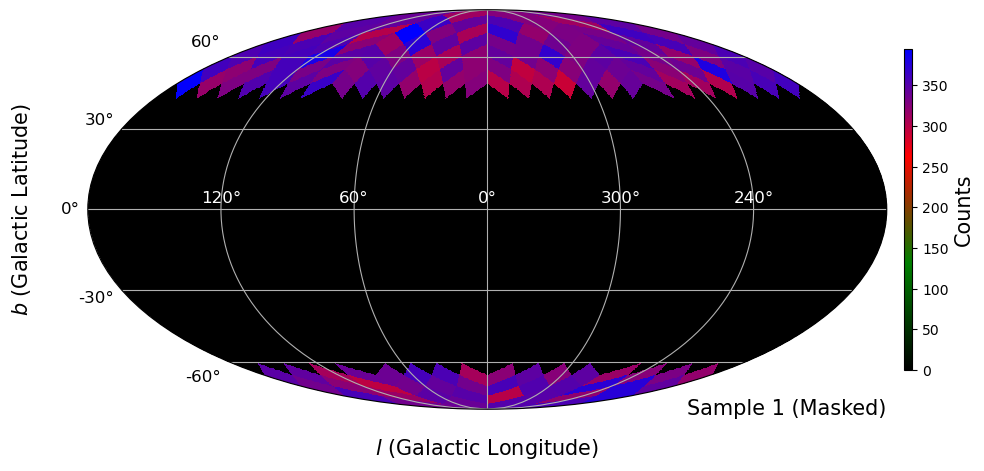

In [2]:
#################################################################################################
df_ = pd.read_csv("mask1/masked_sample_1.dat",sep="\t",header = None)
df_.columns = ['r','th','ph']
th2 = df_['th'].to_numpy()
ph2 = df_['ph'].to_numpy()

m1 = np.zeros(super_pix)
for j in range(len(th2)):
    px1=hp.ang2pix(nside_super,th2[j],ph2[j])
    
    m1[px1] += 1
    
m1min, m1max = np.min(m1),np.max(m1)

custom_cmap = matplotlib.colors.LinearSegmentedColormap.from_list("custom",["black","green","red","blue"])
hp.projview(m1, coord=["G"], cbar=False, cmap=custom_cmap, graticule=True,
            graticule_labels=True, projection_type="mollweide", 
            longitude_grid_spacing=60, latitude_grid_spacing=30, xtick_label_color='white', 
            ytick_label_color='black', graticule_color=None)

plt.xlabel(r"$l$ (Galactic Longitude)", fontsize=15, labelpad=20)  
plt.ylabel(r"$b$ (Galactic Latitude)", fontsize=15, labelpad=20) 
plt.text(0.75, 0.00, "Sample 1 (Masked)", fontsize=15, color='black',
         ha='left', va='center', transform=plt.gca().transAxes)
norm = Normalize(vmin=np.min(m1), vmax=np.max(m1))
cax = plt.axes([1.0, 0.2, 0.01, 0.6])  
color_bar = ColorbarBase(cax, cmap=custom_cmap, norm=norm, orientation='vertical')
color_bar.set_label('Counts', fontsize=15)


plt.savefig('../plots/masked1_map_sample1.pdf', dpi=200, bbox_inches='tight')
plt.show()